# $The$ $Stochastic$ $Alpha$ $Beta$ $Rho$ $(SABR)$ $model.$
There are different techniques to interpolate between the available market quotes, like linear, spline, or tangent spline, interpolation. One of the popular methods for the interpolation of implied volatilities is based on a paper by Hagan.

Formulas: https://en.wikipedia.org/wiki/SABR_volatility_model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's introduce parameters for the Hagan.

In [2]:
CP = 'call'
alpha = .3
beta = .5
rho = -.5
gamma = .4
f_0 = 1.0
time_y = 1.0  # time in years

In [3]:
def hagan_iv(strikes, time_y, f, alpha, beta, rho, gamma):

    if type(strikes) == float:
        strikes = np.array([strikes])
    if strikes is not np.array:
        strikes = np.array(strikes).reshape([len(strikes), 1])

    z = gamma / alpha * np.power(f*strikes, (1.0-beta)/2.0) * np.log(f / strikes)
    x_z = np.log( (np.sqrt(1.0 - 2.0*rho*z + z*z) + z - rho) / (1.0-rho) )


    A = alpha / (np.power(f*strikes, ((1.0 - beta) / 2.0)) * (1.0 + np.power(1.0 - beta,
                                                                             2.0)/24.0*
    np.power(np.log(f/strikes), 2.0)+np.power((1.0-beta), 4.0)/1920.0 * np.power(np.log(f/strikes), 4.0)))


    B1 = 1.0 + (np.power((1.0-beta), 2.0)/24.0*alpha*alpha/
                (np.power((f*strikes), 1-beta)) + 1/4 * (rho*beta*gamma*alpha)/(np.power((f*strikes),
                                                                                        ((1.0-beta)/2.0))) + (2.0 - 3.0*rho*rho)/
                24.0*gamma*gamma)*time_y

    impVol   = A*(z/x_z) * B1

    B2 = 1.0 + (np.power(1-beta, 2.0)/24.0*alpha*alpha/(np.power(f, 2.0 - 2.0*beta)) + 1/4 * (rho*beta*gamma*alpha)/np.power(f, 1.0-beta) +
                (2.0 - 3.0*rho*rho)/24.0*gamma*gamma)*time_y

    # Special treatment for ATM strike price

    impVol[np.where(strikes == f)] = alpha / np.power(f, (1-beta)) * B2
    return impVol


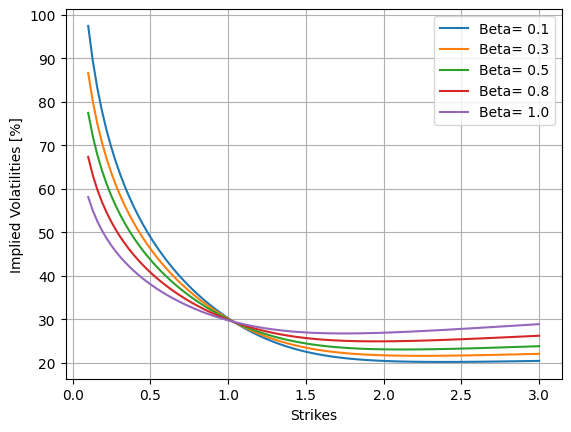

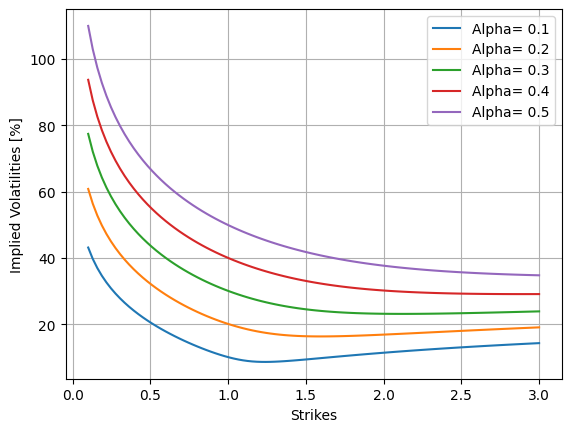

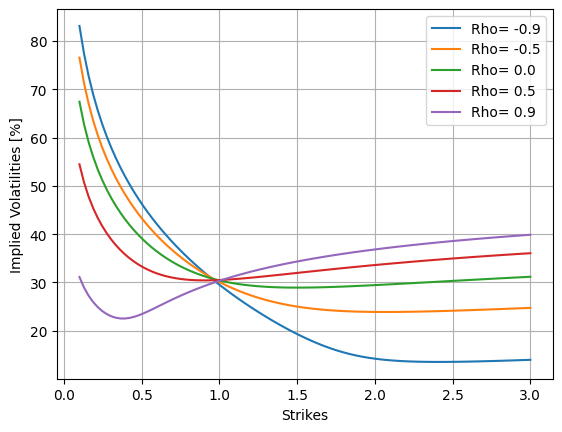

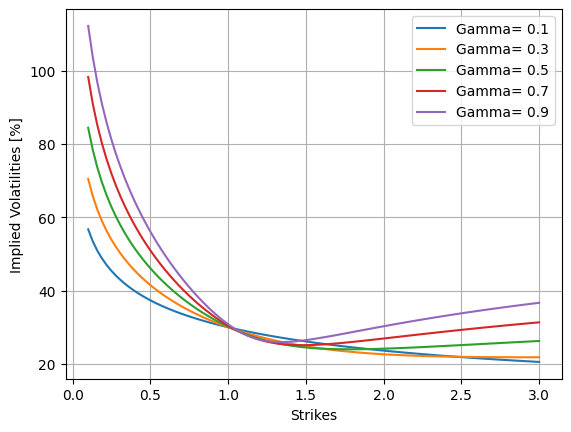

In [4]:
strikes = np.linspace(0.1, 3, 100)

# Figure 1, effect of parameter beta on the implied volatility

Beta = [0.1, 0.3, 0.5, 0.75, 1]
legendL = []
plt.figure(1)
for betaTemp in Beta:
    iv = hagan_iv(strikes, time_y, f_0, alpha, betaTemp, rho, gamma) * 100
    plt.plot(strikes, iv)
    legendL.append(('Beta= {0:.1f}').format(betaTemp))

plt.xlabel('Strikes')
plt.ylabel('Implied Volatilities [%]')
plt.grid()
plt.legend(legendL)


# Figure 2, effect of alpha on the implied volatility

Alpha = [0.1, 0.2, 0.3, 0.4, 0.5]
legendL = []
plt.figure(2)
for alphaTemp in Alpha:
    iv = hagan_iv(strikes, time_y, f_0, alphaTemp, beta, rho, gamma) * 100
    plt.plot(strikes, iv)
    legendL.append(('Alpha= {0:.1f}').format(alphaTemp))

plt.xlabel('Strikes')
plt.ylabel('Implied Volatilities [%]')
plt.grid()
plt.legend(legendL)


# Figure 3, effect of rho on the implied volatility

Rho = [-0.9, -0.45, 0.0, 0.45, 0.9]
legendL = []
plt.figure(3)
for rhoTemp in Rho:
    iv = hagan_iv(strikes, time_y, f_0, alpha, beta, rhoTemp, gamma) * 100
    plt.plot(strikes, iv)
    legendL.append(('Rho= {0:.1f}').format(rhoTemp))

plt.xlabel('Strikes')
plt.ylabel('Implied Volatilities [%]')
plt.grid()
plt.legend(legendL)


# Figure 4, effect of gamma on the implied volatility

Gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
legendL = []
plt.figure(4)
for gammaTemp in Gamma:
    iv = hagan_iv(strikes, time_y, f_0, alpha, beta, rho, gammaTemp) * 100
    plt.plot(strikes, iv)
    legendL.append(('Gamma= {0:.1f}').format(gammaTemp))

plt.xlabel('Strikes')
plt.ylabel('Implied Volatilities [%]')
plt.grid()
plt.legend(legendL)


Different implied volatility shapes under Hagan’s implied volatility parametrization, depending on different model parameters.

In figures given the effect of different model parameters on the implied volatility shapes is shown. Notice that both parameters $\beta$ and $\rho$ have an effect on the implied volatility skew. In practice, $\beta$  is often fixed, whereas $\rho$ is used in a calibration. Parameter $\alpha$ controls the level of the implied volatility smile and $\gamma$ the magnitude of the curvature of the smile.

In [5]:
import scipy.stats as st
import scipy.optimize as optimize
import enum

In [6]:
def hagan_iv(K, T, f, alpha, beta, rho, gamma):
    # We make sure that the input is of array type

    if type(K) == float:
        K = np.array([K])
    if K is not np.array:
        K = np.array(K).reshape([len(K), 1])

    # The strike prices cannot be too close to 0

    K[K < 1e-10] = 1e-10

    z = gamma / alpha * np.power(f * K, (1.0 - beta) / 2.0) * np.log(f / K)
    x_z = np.log((np.sqrt(1.0 - 2.0 * rho * z + z * z) + z - rho) / (1.0 - rho))
    A = alpha / (np.power(f * K, ((1.0 - beta) / 2.0)) * (1.0 + np.power(1.0 - beta, 2.0) / 24.0 *
                                                          np.power(np.log(f / K), 2.0) + np.power((1.0 - beta),
                                                                                                  4.0) / 1920.0 *
                                                          np.power(np.log(f / K), 4.0)))
    B1 = 1.0 + (np.power((1.0 - beta), 2.0) / 24.0 * alpha * alpha / (np.power((f * K),
                                                                               1 - beta)) + 1 / 4 * (
                            rho * beta * gamma * alpha) / (np.power((f * K),
                                                                    ((1.0 - beta) / 2.0))) + (
                            2.0 - 3.0 * rho * rho) / 24.0 * gamma * gamma) * T
    impVol = A * (z / x_z) * B1
    B2 = 1.0 + (np.power(1.0 - beta, 2.0) / 24.0 * alpha * alpha /
                (np.power(f, 2.0 - 2.0 * beta)) + 1.0 / 4.0 * (rho * beta * gamma *
                                                               alpha) / np.power(f, (1.0 - beta)) + (
                            2.0 - 3.0 * rho * rho) / 24.0 * gamma * gamma) * T

    # Special treatment of ATM strike value

    impVol[np.where(K == f)] = alpha / np.power(f, (1 - beta)) * B2
    return impVol


In [7]:
def LocalVarianceBasedOnSABR(s0, frwd, r, alpha, beta, rho, volvol):
    # Define shock size for approximating derivatives

    dt = 0.001
    dx = 0.001

    # Function for Hagan's implied volatility approximation

    sigma = lambda x, t: hagan_iv(x, t, frwd, alpha, beta, rho, volvol)

    # Derivatives

    dsigmadt = lambda x, t: (sigma(x, t + dt) - sigma(x, t)) / dt
    dsigmadx = lambda x, t: (sigma(x + dx, t) - sigma(x - dx, t)) / (2.0 * dx)
    d2sigmadx2 = lambda x, t: (sigma(x + dx, t) + sigma(x - dx, t) - 2.0 * sigma(x, t)) / (dx * dx)
    omega = lambda x, t: sigma(x, t) * sigma(x, t) * t
    domegadt = lambda x, t: sigma(x, t) ** 2.0 + 2.0 * t * sigma(x, t) * dsigmadt(x, t)
    domegadx = lambda x, t: 2.0 * t * sigma(x, t) * dsigmadx(x, t)
    # d2omegadx2 = lambda x,t: 2.0*t*(dsigmadx(x,t))**2.0 + 2.0*t*sigma(x,t)*d2sigmadx2(x,t)
    d2omegadx2 = lambda x, t: 2.0 * t * np.power(dsigmadx(x, t), 2.0) + 2.0 * t * sigma(x, t) * d2sigmadx2(x, t)

    term1 = lambda x, t: 1.0 + x * domegadx(x, t) * (0.5 - np.log(x / (s0 * np.exp(r * t))) / omega(x, t))
    term2 = lambda x, t: 0.5 * np.power(x, 2.0) * d2omegadx2(x, t)
    term3 = lambda x, t: 0.5 * np.power(x, 2.0) * np.power(domegadx(x, t), 2.0) * (
                -1.0 / 8.0 - 1.0 / (2.0 * omega(x, t)) \
                + np.log(x / (s0 * np.exp(r * t))) * np.log(x / (s0 * np.exp(r * t))) / (2 * omega(x, t) * omega(x, t)))

    # Final expression for local variance

    sigmalv2 = lambda x, t: (domegadt(x, t) + r * x * domegadx(x, t)) / (term1(x, t) + term2(x, t) + term3(x, t))
    return sigmalv2

In [8]:
def BS_Call_Put_Option_Price(CP, S_0, K, sigma, tau, r):
    if K is list:
        K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))
          * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    if CP == 'call':
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == 'put':
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1) * S_0
    return value

In [9]:
# Implied volatility method

def ImpliedVolatility(CP, marketPrice, K, T, S_0, r):
    # To determine initial volatility we define a grid for sigma
    # and interpolate on the inverse function

    sigmaGrid = np.linspace(0, 2, 200)
    optPriceGrid = BS_Call_Put_Option_Price(CP, S_0, K, sigmaGrid, T, r)
    sigmaInitial = np.interp(marketPrice, optPriceGrid, sigmaGrid)
    print("Initial volatility = {0}".format(sigmaInitial))

    # Use already determined input for the local-search (final tuning)

    func = lambda sigma: np.power(BS_Call_Put_Option_Price(CP, S_0, K, sigma, T, r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    print("Final volatility = {0}".format(impliedVol))
    return impliedVol

In [10]:
def EUOptionPriceFromMCPaths(CP, S, K, T, r):
    # S is a vector of Monte Carlo samples at T

    if CP == 'call':
        return np.exp(-r * T) * np.mean(np.maximum(S - K, 0.0))
    elif CP == 'put':
        return np.exp(-r * T) * np.mean(np.maximum(K - S, 0.0))

In [11]:
def mainCalculation():
    # For the SABR model we take beta =1 and rho =0 (as simplification)

    beta = 1.0
    rho = 0.0

    # Other model parameters

    volvol = 0.2
    s0 = 1.0
    T = 10.0
    r = 0.05
    alpha = 0.2
    f_0 = s0 * np.exp(r * T)
    CP = 'call'

    # Monte Carlo settings

    NoOfPaths = 25000
    NoOfSteps = (int)(100 * T)

    # We define the market to be driven by Hagan's SABR formula
    # Based on this formula we derive the local volatility/variance

    sigma = lambda x, t: hagan_iv(x, t, f_0, alpha, beta, rho, volvol)

    # Local variance based on the Hagan's SABR formula

    sigmalv2 = LocalVarianceBasedOnSABR(s0, f_0, r, alpha, beta, rho, volvol)

    # Monte Carlo simulation

    dt = T / NoOfSteps
    np.random.seed(4)
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    S = np.zeros([NoOfPaths, NoOfSteps + 1])

    S[:, 0] = s0;
    time = np.zeros([NoOfSteps + 1, 1])

    for i in range(0, NoOfSteps):

        # This condition is necessary as for t=0 we cannot compute implied
        # volatilities

        if time[i] == 0.0:
            time[i] = 0.0001

        # print('current time is {0}'.format(time[i]))

        # Standarize Normal(0,1)

        Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])

        # Compute local volatility

        S_i = np.array(S[:, i]).reshape([NoOfPaths, 1])
        temp = sigmalv2(S_i, time[i])
        sig = np.real(temp)
        np.nan_to_num(sig)

        # Because of discretizations we may encouter negative variance which
        # is set to 0 here.

        sig = np.maximum(sig, 1e-14)
        sigmaLV = np.sqrt(sig)

        # Stock path

        S[:, i + 1] = S[:, i] * (1.0 + r * dt + sigmaLV.transpose() * Z[:, i] * np.sqrt(dt))

        # We force that at each time S(t)/M(t) is a martingale

        S[:, i + 1] = S[:, i + 1] - np.mean(S[:, i + 1]) + s0 * np.exp(r * time[i])

        # Make sure that after moment matching we don't encounter negative stock values

        S[:, i + 1] = np.maximum(S[:, i + 1], 1e-14)

        # Adjust time

        time[i + 1] = time[i] + dt

    # Plot some results

    K = np.linspace(0.2, 5.0, 25)
    # c_n = np.array([-1.5, -1.0, -0.5,0.0, 0.5, 1.0, 1.5])
    # K= s0*np.exp(r*T) * np.exp(0.1 * c_n * np.sqrt(T))
    OptPrice = np.zeros([len(K), 1])
    IV_Hagan = np.zeros([len(K), 1])
    IV_MC = np.zeros([len(K), 1])
    for (idx, k) in enumerate(K):
        OptPrice[idx] = EUOptionPriceFromMCPaths(CP, S[:, -1], k, T, r)
        IV_Hagan[idx] = sigma([k], T) * 100.0
        IV_MC[idx] = ImpliedVolatility(CP, OptPrice[idx], k, T, s0, r) * 100.0

    # Plot the option prices

    plt.figure(1)
    plt.plot(K, OptPrice)
    plt.grid()
    plt.xlabel('strike')
    plt.ylabel('option price')

    # Plot the implied volatilities

    plt.figure(2)
    plt.plot(K, IV_Hagan)
    plt.plot(K, IV_MC, '-r')
    plt.grid()
    plt.xlabel('strike')
    plt.ylabel('implied volatility')
    plt.legend(['Hagan', 'Monte Carlo'])
    plt.axis([np.min(K), np.max(K), 0, 40])

Initial volatility = [0.27197487]
Final volatility = [0.27203909]
Initial volatility = [0.25173097]
Final volatility = [0.25175802]
Initial volatility = [0.23374096]
Final volatility = [0.23381172]
Initial volatility = [0.2217417]
Final volatility = [0.22175398]
Initial volatility = [0.21412196]
Final volatility = [0.21414303]
Initial volatility = [0.20916511]
Final volatility = [0.20916988]
Initial volatility = [0.20628419]
Final volatility = [0.20628155]
Initial volatility = [0.20526274]
Final volatility = [0.20525653]
Initial volatility = [0.20518872]
Final volatility = [0.20518349]
Initial volatility = [0.20596581]
Final volatility = [0.2059647]
Initial volatility = [0.20727968]
Final volatility = [0.20728477]
Initial volatility = [0.20886942]
Final volatility = [0.20887863]
Initial volatility = [0.21052603]
Final volatility = [0.21053055]
Initial volatility = [0.21232173]
Final volatility = [0.21233457]
Initial volatility = [0.21420274]
Final volatility = [0.21423594]
Initial vola

/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_15853/3477140874.py:4: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))


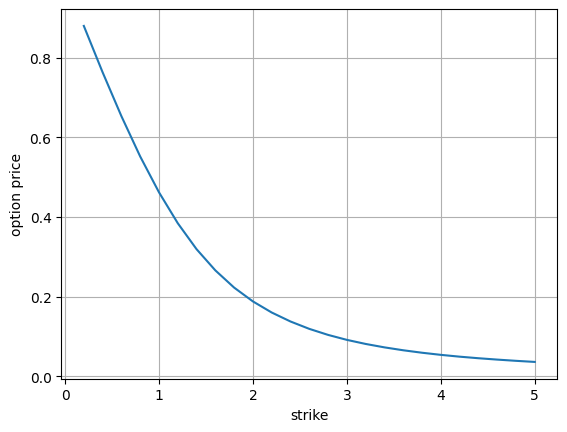

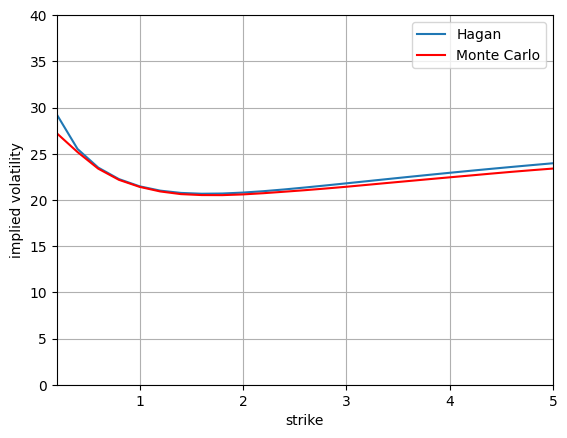

In [12]:
mainCalculation()

Local volatility models resemble very well the implied volatilities that we observe in market option quotes, and they are used as an input to the LV model.
However, LV models may suffer from significant mispricing inaccuracy when dealing with financial derivatives products that depend on the volatility paths and,
generally, on transition density functions. This information is simply not “coded” in the LV model framework.